In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from zipfile import ZipFile

In [2]:
with ZipFile('/content/Dataset.zip', 'r') as zip:
  zip.extractall()

In [3]:
df = pd.read_csv(os.path.join("/content/Dataset/train/train.csv"))

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df[df['toxic']==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


# Data Preprocessing

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text'].values # .values akan merubah panda series menjadi numpy array
y = df[df.columns[2:]].values # .values akan merubah panda series menjadi numpy array
print(len(X))
print(len(y))

159571
159571


In [8]:
MAX_FEATURES = 200000

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1750,
                               output_mode='int')

In [10]:
vectorizer.adapt(X)

In [11]:
vectorizer.get_vocabulary() # index dari setiap kata menunjukan token untuk kata tersebut

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [12]:
# object tokenizer ini akan mentokenisasi setiap input kata sesuai dengan tokenisasi yang telah ia berikan...
# pada X (ketika vectorizer.adapt(x))
vectorizer('halo, namaku raja umurku 21 tahun')

<tf.Tensor: shape=(1750,), dtype=int64, numpy=array([9495,    1, 7070, ...,    0,    0,    0])>

In [13]:
# SELEUMNYA VECTORIZER TELAH DI TRAIN DENGAN X DAN MEMBERIKAN TOKEN UNIK UTK SETIAP KATA PADA X
# KALI INI OBJECT VECTORIZER AKAN MERUBAH X MENJADI SEQUENCE OF INTEGER
vectorized_text = vectorizer(X)
vectorized_text

<tf.Tensor: shape=(159571, 1750), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [14]:
# 159571 adalah total training data, 1750 adalah panjang kalimat per training data
# panjangnya 1750 karena parameter output_sequence_length=1750
# VECTORIZER JUGA MEMBERIKAN PADDING SECARA OTOMATIS PADA KALIMAT DIBAWAH 1750 DAN MEMOTONG KALIMAT YANG DIATAS 1750
vectorized_text.shape

TensorShape([159571, 1750])

In [15]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [16]:
# dataset dengan total 159571 dibagi menjadi beberapa batches, dengan setiap batch sebanyak 16 examples
# sehingga total bacthes 9974
len(dataset)

9974

In [17]:
9974*16

159584

In [18]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [19]:
print(batch_x.shape)
print(batch_y.shape)

(16, 1750)
(16, 6)


In [20]:
# train, val, test split

# mengambil 70% dari data untuk training
train = dataset.take(int(len(dataset)*.7))

# mengskip 70% data awal dan mengambil 20% (70-90%) untuk validation
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))

# mengskip 90% data awal dan mengambil 10% (90-100%) untuk testing
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*.1))

In [21]:
print(len(train))
print(len(val))
print(len(test))

6981
1994
997


In [22]:
print(6981+1994+997)

9972


In [23]:
train.as_numpy_iterator().next()

(array([[  21,  232,    8, ...,    0,    0,    0],
        [ 117, 2681,    4, ...,    0,    0,    0],
        [  94,    8, 1466, ...,    0,    0,    0],
        ...,
        [ 257,   86,  844, ...,    0,    0,    0],
        [2292,    9,    6, ...,    0,    0,    0],
        [ 534,   52,  154, ...,    0,    0,    0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0]]))

# Build The Model

In [24]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

In [25]:
model = Sequential([])

# Embedding layer, gives 32 vector values to each word
# MAX_FEATURES is  the input for the layer. added by 1 karena last index tambahan 1 itu untuk token padding
model.add(Embedding(MAX_FEATURES+1, 32))

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Fully Connected Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2)) # Dropout layers to prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2)) # Dropout layers to prevent overfitting
model.add(Dense(32, activation='relu'))

# Output Layer to predict 6 classes
model.add(Dense(6, activation='sigmoid'))

In [26]:
model.compile(optimizer='adam',
              loss='BinaryCrossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [28]:
class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss')<0.018 and logs.get('val_accuracy')>0.99:
      print('\nDesired Validation Loss and Validation Accuracy Achieved')
      self.model.stop_training = True

callback = myCallBack()

In [29]:
history = model.fit(train, epochs=15, validation_data=val, verbose=2, callbacks=[callback])

Epoch 1/15
6981/6981 - 840s - loss: 0.0652 - accuracy: 0.9659 - val_loss: 0.0458 - val_accuracy: 0.9940 - 840s/epoch - 120ms/step
Epoch 2/15
6981/6981 - 679s - loss: 0.0459 - accuracy: 0.9850 - val_loss: 0.0416 - val_accuracy: 0.9944 - 679s/epoch - 97ms/step
Epoch 3/15
6981/6981 - 668s - loss: 0.0421 - accuracy: 0.9812 - val_loss: 0.0364 - val_accuracy: 0.9941 - 668s/epoch - 96ms/step
Epoch 4/15
6981/6981 - 668s - loss: 0.0382 - accuracy: 0.9770 - val_loss: 0.0326 - val_accuracy: 0.9946 - 668s/epoch - 96ms/step
Epoch 5/15
6981/6981 - 665s - loss: 0.0344 - accuracy: 0.9821 - val_loss: 0.0304 - val_accuracy: 0.9938 - 665s/epoch - 95ms/step
Epoch 6/15
6981/6981 - 663s - loss: 0.0313 - accuracy: 0.9812 - val_loss: 0.0271 - val_accuracy: 0.9934 - 663s/epoch - 95ms/step
Epoch 7/15
6981/6981 - 661s - loss: 0.0282 - accuracy: 0.9596 - val_loss: 0.0242 - val_accuracy: 0.9935 - 661s/epoch - 95ms/step
Epoch 8/15
6981/6981 - 660s - loss: 0.0257 - accuracy: 0.9796 - val_loss: 0.0220 - val_accuracy:

In [30]:
model.save('Toxicity_Detector.h5')

<Figure size 800x500 with 0 Axes>

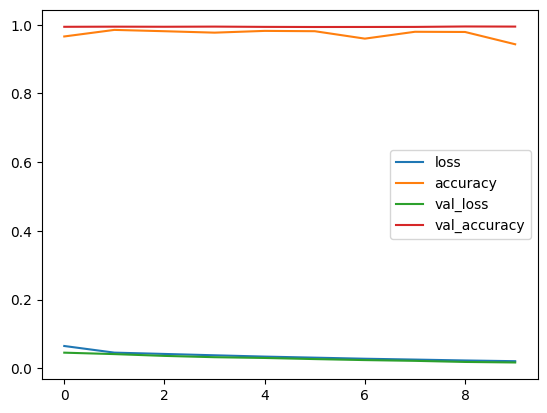

In [31]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# PREDICTION

In [32]:
input_text = vectorizer("i'm gonna whoop your ass off")

# ini masih berup tensor, jika ingin diprediksi oleh model mesti dirubah menjadi numpy array
# dan di expand dimensinya
type(input_text)

tensorflow.python.framework.ops.EagerTensor

In [33]:
# mengconvert tensor menjadi np array dan merubah dimensinya
type(np.expand_dims(input_text,0))

numpy.ndarray

In [34]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 769ms/step


In [35]:
# menampilkan column target variabel y
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [36]:
# index 0 untuk toxic, 1 untuk severe_toxic, 2 untuk obscene dan seterusnya
res

array([[0.9591298 , 0.06634069, 0.8778945 , 0.00311619, 0.20994958,
        0.00380813]], dtype=float32)

In [37]:
# hasil prediksi dengan threshold 0,5
res > 0.5

array([[ True, False,  True, False, False, False]])

In [38]:
# astype() merubah tipenya menjadi integer
(res > .5).astype(int)

array([[1, 0, 1, 0, 0, 0]])

In [39]:
# mengambil batch dari test set, dan memisahkan x dan y nya
batch_test = test.as_numpy_iterator().next()
batch_test_X, batch_test_y = batch_test

In [40]:
# prediksi untuk data test set dengan threshold 0,5
# astype() merubah tipenya menjadi integer
(model.predict(batch_test_X) > .5).astype(int)

1/1 [==============================] - 0s 63ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [41]:
# bandingkan dengan actual target variabel di test set
batch_test_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Model Evaluation

In [42]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [43]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [44]:
# looping untuk setiap batch dalam test set (setiap masing-masing batch memiliki x dan y nya)
for batch in test.as_numpy_iterator():

  # memisahkan x dan y dalam setiap batch
  X_true, y_true = batch
  # memprediksi nilai x dan mengassignnya ke variabel y_pred
  y_pred = model.predict(X_true)

  # merubah baik y_true (actual label) dan y_pred (predicted label) menjadi 1D vector array
  y_true = y_true.flatten()
  y_pred = y_pred.flatten()

  # memberikan penilaian untuk setiap batch test data dengan membandingkan actual label dengan predicted label
  precision.update_state(y_true, y_pred)
  recall.update_state(y_true, y_pred)
  accuracy.update_state(y_true, y_pred)

1/1 [==============================] - 0s 57ms/step


In [45]:
print(f'Precision score = {precision.result().numpy()}\nRecall Score = {recall.result().numpy()}\nAccuracy Score = {accuracy.result().numpy()}')

Precision score = 0.9197922945022583
Recall Score = 0.89853435754776
Accuracy Score = 0.5105316042900085


# Using Gradio

In [46]:
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
 

In [47]:
import gradio as gr

In [48]:
model = tf.keras.models.load_model('Toxicity_Detector.h5')

In [49]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text = ''
  for idx,col in enumerate(df.columns[2:]):
    text += f'{col}: {results[0][idx]>.5}\n'

  return text

In [50]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                         outputs='text')

<ipython-input-50-421e52a3fcfe>:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
<ipython-input-50-421e52a3fcfe>:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
<ipython-input-50-421e52a3fcfe>:2: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),


In [51]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2b5b9af5ea48cc973f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
